In [1]:
###AUTHORS###
# SHASHANK KATHAVATE
# SSK210005
# GAURAV PATIL
# GVP190001

The code can be run on GPU or CPU, however the cpu execution take longer. If there is no GPU available please use the same coed on google colab with the GPU enabled. The code requires the files "fashion-mnist_train.csv" and "fashion-mnist_test.csv" in the same directory to run. The outputs will be displayed on the jupyter notebook.

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import warnings
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.nn import *
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from torch.optim import Adam
from torch.utils.data import DataLoader
warnings.filterwarnings("ignore")


In [3]:
trainSet = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testSet = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
learningRate = 0.05
batchSize = 128
numWorkers = 1

idx = list(range(len(trainSet)))
np.random.shuffle(idx)
spt = int(np.floor(0.1 * len(trainSet)))
trainSamp = SubsetRandomSampler(idx[:spt])
validSamp = SubsetRandomSampler(idx[spt:])

trainLoader = DataLoader(dataset=trainSet, batch_size=batchSize,num_workers=numWorkers,sampler=trainSamp)
validationLoader = DataLoader(dataset=trainSet, batch_size=batchSize,num_workers=numWorkers,sampler=validSamp)
testLoader = DataLoader(dataset=testSet, batch_size=batchSize,num_workers=numWorkers)

xTrainSet, yTrainSet = next(iter(trainLoader))
xValidationSet, yValidationSet = next(iter(validationLoader))
print(xTrainSet.reshape(-1,32,32).shape)

torch.Size([384, 32, 32])


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2855e0220>)

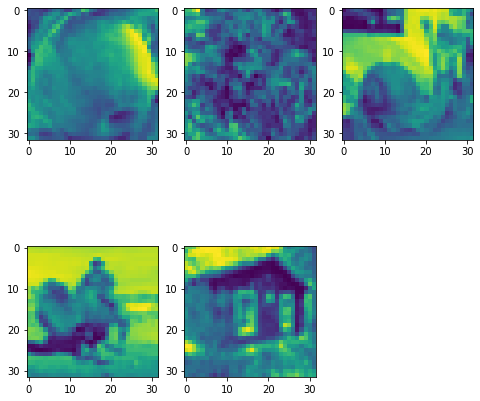

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTrainSet.reshape(-1,32,32)[10])
plt.subplot(232), plt.imshow(xTrainSet.reshape(-1,32,32)[20])
plt.subplot(233), plt.imshow(xTrainSet.reshape(-1,32,32)[30])
plt.subplot(234), plt.imshow(xTrainSet.reshape(-1,32,32)[40])
plt.subplot(235), plt.imshow(xTrainSet.reshape(-1,32,32)[50])

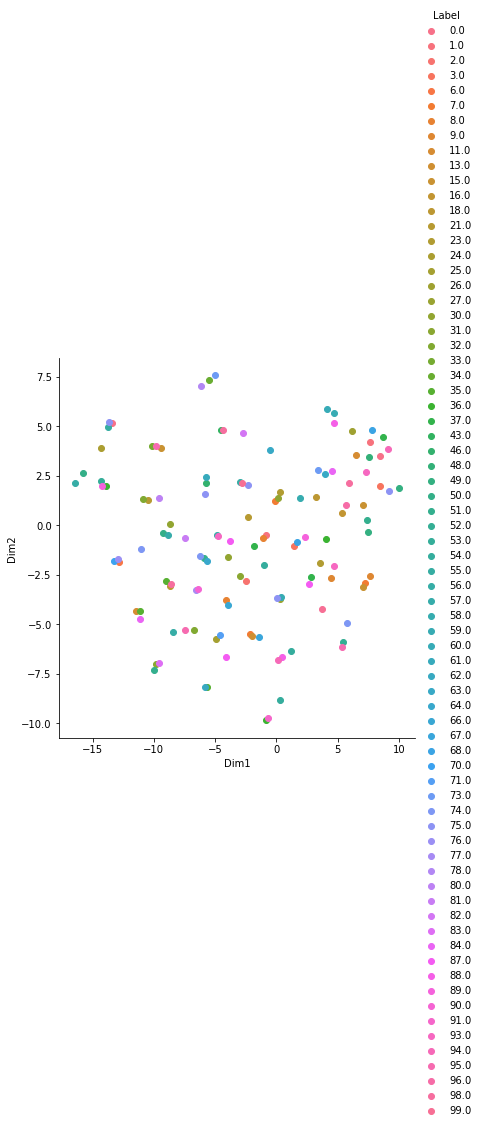

In [6]:
#Exploratory data analysis using TSNE
trainS = StandardScaler().fit_transform(xTrainSet.reshape(-1,1024))
x1000 = trainS[:batchSize,:]
y1000 = yTrainSet[:batchSize]
model = TSNE(n_components=2,random_state=0)
tData = model.fit_transform(x1000)
tData = np.vstack((tData.T,y1000.T)).T
tDataDf = pd.DataFrame(data=tData,columns= ["Dim1","Dim2","Label"])
sns.FacetGrid(tDataDf,hue="Label",size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

In [7]:

class AlexNet(Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 3, stride = 2),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 3, stride = 2),
            Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(96),
            ReLU(inplace=True),
            Conv2d(96, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = Sequential(
            Dropout(0.5),
            Linear(288, 1024),
            ReLU(inplace=True),
            Dropout(0.5),
            Linear(1024, 512),
            ReLU(inplace=True),
            Linear(512, 100))
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
model = AlexNet()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
lossFunc = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    lossFunc = lossFunc.cuda()
    
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 32, kernel_size=(3, 3),

In [9]:
trainLossList = []
validationLossList = []

def trainData(epoch):
    model.train()
    trainLossSum = 0
    validationLossSum = 0
    for trainImages,trainLabels in trainLoader:
        trainImages,trainLabels = Variable(trainImages), Variable(trainLabels)
        if torch.cuda.is_available():
            trainImages = trainImages.cuda()
            trainLabels = trainLabels.cuda()

        yPredTrain = model(trainImages)
        optimizer.zero_grad()
        trainLoss = lossFunc(yPredTrain,trainLabels)
        trainLoss.backward()
        optimizer.step()
        trainLossSum += trainLoss.item()*trainImages.size(0)
    
    for validationImages, validationLabels in validationLoader:
        validationImages,validationLabels = Variable(validationImages), Variable(validationLabels)
        if torch.cuda.is_available():
            validationImages = validationImages.cuda()
            validationLabels = validationLabels.cuda()
        
        yPredValidation = model(validationImages)
        validationLoss = lossFunc(yPredValidation,validationLabels)
        validationLossSum += validationLoss.item()*validationImages.size(0)
    
    trainLossSum = trainLossSum/len(trainLoader.sampler)
    validationLossSum = validationLossSum/len(validationLoader.sampler)
    trainLossList.append(trainLossSum)
    validationLossList.append(validationLossSum)
    if epoch%2 == 0:
        print('Epoch: ',epoch+1,'\t','loss: ',trainLossSum)



In [10]:
totalEpochs = 5

for epoch in range(totalEpochs):
    trainData(epoch)


Epoch:  1 	 loss:  12.685841220092774
Epoch:  3 	 loss:  4.629677822875976
Epoch:  5 	 loss:  4.740336068725586


<function matplotlib.pyplot.show(close=None, block=None)>

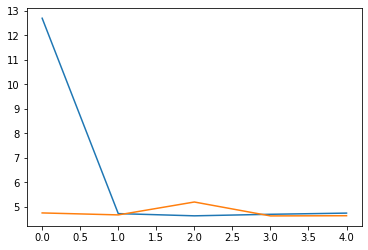

In [11]:
#plotting the losses
plt.plot(trainLossList,label = 'Training')
plt.plot(validationLossList,label='Validation')
plt.show

In [12]:
#Accuracy
def calcAccuracy(loader):
    totalLoss = 0
    correctClass = [0] * 100
    totalClassCount = [0] * 100
    for images,labels in loader:
        if torch.cuda.is_available():
            yTrainPred = model(images.cuda())
            labels = labels.cuda()
        else:
            yTrainPred = model(images)
        
        lossCalc = lossFunc(yTrainPred,labels)
        totalLoss += lossCalc.item()*images.size(0)

        blank, prediction = torch.max(yTrainPred,1)
        trueLabelPred = np.squeeze(prediction.eq(labels.data.view_as(prediction)))

        for ix in range(len(labels)):
            lb = labels.data[ix]
            correctClass[lb] += trueLabelPred[ix].item()
            totalClassCount[lb] += 1

    accuracy = np.sum(correctClass) / np.sum(totalClassCount)
    return accuracy


trainAccuracy = calcAccuracy(trainLoader)
validationAccuracy = calcAccuracy(validationLoader)

print("Train Accuracy= ",trainAccuracy)
print("Validation Accuracy= ",validationAccuracy)

Train Accuracy=  0.013
Validation Accuracy=  0.012088888888888889


['Bed', 'Woman', 'Woman', 'Woman', 'Woman']


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x289580910>)

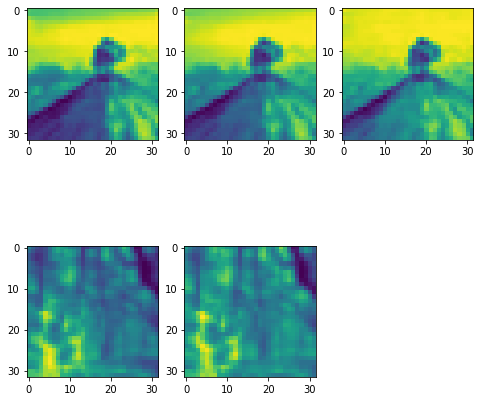

In [13]:
#Test set predicitons
xTestSet, yTestSet = next(iter(testLoader))

if torch.cuda.is_available():
    with torch.no_grad():
        yTestPred = model(xTestSet.cuda())
        softmax = torch.exp(yTestPred).cpu()
else:
    yTestPred = model(xTestSet)
    softmax = torch.exp(yTestPred.detach())
    
probability = list(softmax.numpy())
predictions = np.argmax(probability, axis=1)
labelDict = {
    0:"Beaver",1:"Dolphin",2:"Otter",3:"Seal",4:"Whale",
    5:"Aquarium Fish",6:"Flatfish",7:"Ray",8:"Shark",9:"Trout",
    10:"Orchids",11:"Poppies",12:"Roses",13:"Sunflowers",14:"Tulips",
    15:"Bottles",16:"Bowls",17:"Cans",18:"Cups",19:"Plates",
    20:"Apples",21:"Mushrooms",22:"Oranges",23:"Pears",24:"Sweet Peppers",
    25:"Clock",26:"Computer Keyboard",27:"Lamp",28:"Telephone",29:"Television",
    30:"Bed",31:"Chair",32:"Couch",33:"Table",34:"Wardrobe",
    35:"Bee",36:"Beetle",37:"Butterfly",38:"Caterpillar",39:"Cockroach",
    40:"Bear",41:"Leopard",42:"Lion",43:"Tiger",44:"Wolf",
    45:"Bridge",46:"Castle",47:"House",48:"Road",49:"Skyscraper",
    50:"Cloud",51:"Forest",52:"Mountain",53:"Plain",54:"Sea",
    55:"Camel",56:"Cattle",57:"Chimpanzee",58:"Elephant",59:"Kangaroo",
    60:"Fox",61:"Porcupine",62:"Possum",63:"Racoon",64:"Skunk",
    65:"Crab",66:"Lobster",67:"Snail",68:"Spider",69:"Worm",
    70:"Baby",71:"Boy",72:"Girl",73:"Man",74:"Woman",
    75:"Crocodile",76:"Dinasaur",77:"Lizard",78:"Snake",79:"Turtle",
    80:"Hamster",81:"Mouse",82:"Rabbit",83:"Shrew",84:"Squirrel",
    85:"Maple",86:"Oak",87:"Palm",88:"Pine",89:"Willow",
    90:"Bicycle",91:"Bus",92:"MotorCycle",93:"Pickup Truck",94:"Train",
    95:"Lawn-mover",96:"Rocket",97:"Street car",98:"Tank",99:"Tracktor"
}
#Results for the 10000 test data images. The above dictionary represents the classification label for the data.
predictions = [labelDict[i] for i in predictions]
#First 5 Predictions
print(predictions[:5])
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTestSet.reshape(-1,32,32)[0])
plt.subplot(232), plt.imshow(xTestSet.reshape(-1,32,32)[1])
plt.subplot(233), plt.imshow(xTestSet.reshape(-1,32,32)[2])
plt.subplot(234), plt.imshow(xTestSet.reshape(-1,32,32)[3])
plt.subplot(235), plt.imshow(xTestSet.reshape(-1,32,32)[4])

# The Above show the first 5 predictions of the test data set. It may be seen that they have an accuracy of almost 50%. With the prediction on image 4 being incorrect.